Animating oil dispersion on the Salish Sea Atlantis grid. Original code written by Bec Gordon & Javier Porobic, CSIRO, modified to create an animated GIF

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
from pathlib import Path
from pprint import pprint
from netCDF4 import Dataset
import matplotlib.cm as cm
from IPython.display import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
# salish sea atlantis box shapefile.
shapefile_SSAM = Path("/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp")
data_df = gpd.read_file(shapefile_SSAM)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
box_area = data_df['AREA']
box_volume = box_area * box_depth
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]

In [3]:
numBoxes = len(data_df.BOX_ID)
numLayers = 7
print(numBoxes)
print(numLayers)

130
7


In [4]:
scenarios = {
"5b_Turn_Point_Diluted_bitumen": {
            "Density": 1011.2, #kg/m^3
            "spill_volume": 2000 #m^3
        },

    "6a_VancouverHarbour_BunkerC" : {
            "Density": 995.3, #kg/m^3
            "spill_volume": 15 #m^3
        },

    "7a_JohnsonStrait_BunkerC" : {
            "Density": 995.3, #kg/m^3
            "spill_volume": 1000 #m^3
         },

    "4a_ActivePass_Diesel" : {
            "Density": 831.0, #kg/m^3
            "spill_volume": 500 #m^3
        }
    }

In [5]:
file_id = int(input( ))
scenario = {1 : "5b_Turn_Point_Diluted_bitumen",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",
            4 : "4a_ActivePass_Diesel",}

print("\nScenario running  :", scenario[file_id], sep = " ")


Scenario running  : 4a_ActivePass_Diesel


In [6]:
oil_per_particle = scenarios[scenario[file_id]]["Density"] * scenarios[scenario[file_id]]["spill_volume"] / 100

In [29]:
file_location = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/')
Date = '2020-06-20' 
file_paths = sorted([p for p in file_location.glob('Atlantis_' + str(scenario[file_id]) + '_' + str(Date) + '.nc')])

file_paths

[PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/Atlantis_4a_ActivePass_Diesel_2020-06-20.nc')]

In [30]:
new_data = np.zeros((numBoxes))

netcdfFileName = "Probabilities_" + scenario[file_id] + "-" + Date + ".nc"
try:
    os.remove(netcdfFileName)
except:
    pass
ncfile = Dataset(netcdfFileName, "w", format="NETCDF4", clobber=True)
Dataset.set_fill_on(ncfile)

# Dimensions
#time = ncfile.createDimension("t", None)
b = ncfile.createDimension("b", numBoxes)
#z = ncfile.createDimension("z", numLayers)

In [31]:
# Variables
#times = ncfile.createVariable("t",np.float64, ("t",))
oil = ncfile.createVariable("oil",np.float64,("b"))

oil.units = "kgOil/m^3"
oil.long_name = "Oil"

#times.units = "seconds since " + d
#times.dt = outputDT
#times.long_name = "time"

In [32]:
#testing the conversion back to particle probabilities out of 100 at each time step for a single file
for path in file_paths :
   oil_data = xr.open_dataset(str(path), decode_cf=True)
   oil_variable = np.ma.filled(oil_data.variables["oil"], np.nan) # [t,b]
print(oil_variable[:,60])

for steps in range (0, len(oil_variable)):
      oil_variable[steps,:] = oil_variable[steps,:] * (box_volume / oil_per_particle) 

print(oil_variable[:,60])

[0.00000000e+00 1.26376696e-08 7.74708896e-11 3.16605864e-13
 7.16507542e-14 2.91645140e-16 8.96916613e-19 2.46492369e-21
 5.16712554e-24 2.11168602e-26 8.62997636e-29 3.52687390e-31
 1.44135272e-33 5.89047902e-36 2.40730385e-38 9.34178845e-41
 0.00000000e+00]
[0.00000000e+00 4.90412638e-02 3.00630611e-04 1.22860877e-06
 2.78045213e-07 1.13174712e-09 3.48054076e-12 9.56528985e-15
 2.00513524e-17 8.19452909e-20 3.34891606e-22 1.36862537e-24
 5.59325897e-27 2.28583706e-29 9.34169246e-32 3.62513917e-34
 0.00000000e+00]


In [33]:
oil_sum = oil_variable.sum(axis=0)

print(oil_sum.sum(0))

100.3278977293033


In [34]:
# populating probability files
for path in file_paths :
   oil_data = xr.open_dataset(str(path), decode_cf=True)
   oil_variable = np.ma.filled(oil_data.variables["oil"], np.nan) # [t,b]
   for steps in range (0, len(oil_variable)):
      oil_variable[steps,:] = oil_variable[steps,:] * (box_volume / oil_per_particle)
      for box in range (0, numBoxes):
         if oil_variable[steps,box] > 4.9:
            oil_variable[steps,box] = 1
         else :
            oil_variable[steps,box] = 0
   oil_probs = oil_variable.sum(axis=0)
   new_data = new_data + oil_probs
print(new_data)

oil[:] = new_data

ncfile.close()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Plot_Probs_4a_ActivePass_Diesel-2020-06-20.png


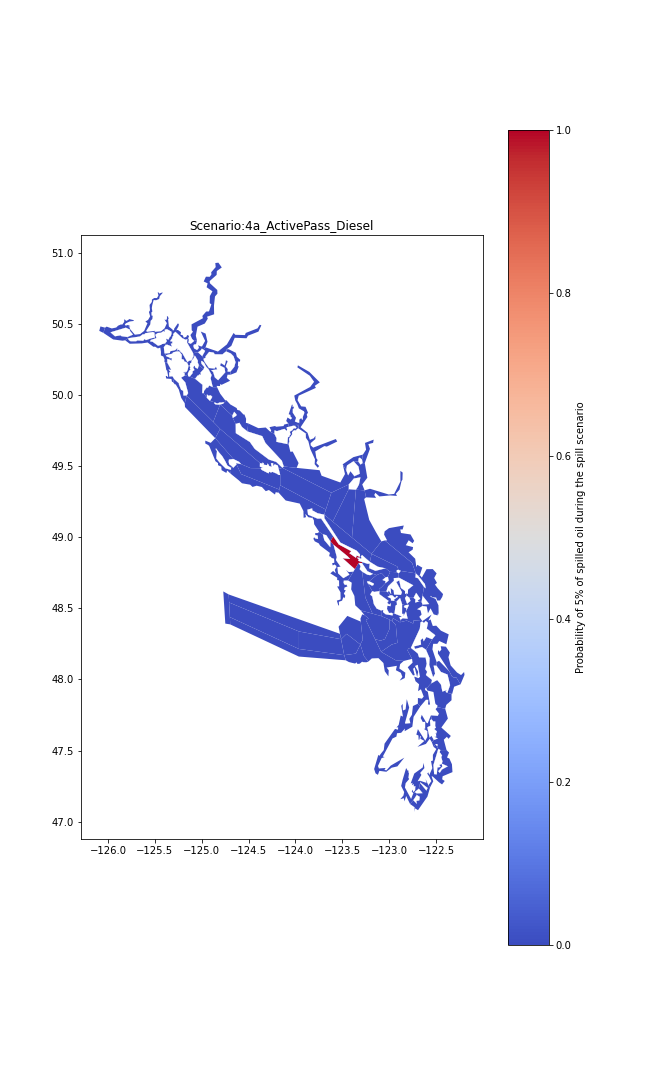

In [35]:
# Uncomment below if adding a log scale so the boxes show the proportion of contamination
# import matplotlib.colors as colors

_cmap = cm.coolwarm #winter #viridis #Paired
file_names = []

land_df = data_df.loc[land_boxes]
data_df['oil'] = new_data #particle probabilities out of 100
data_df.loc[land_boxes, 'oil'] = -1

ax = data_df.plot(figsize=(9, 15), column = 'oil', cmap=_cmap, 
    vmin=-0, vmax = 1,
    legend=True, legend_kwds={'label': "Probability of 5% of spilled oil during the spill scenario"
    },)

land_df.plot(ax=ax, color='white')
#ax.scatter(plon, plat, s=10, color='lightgrey', zorder=20) #s=0.001
ax.set_title(str('Scenario:' + scenario[file_id]))
ax.set_facecolor('white')

#plt.tight_layout()
plot_name = 'Plot_Probs_' + scenario[file_id] + '-' + Date + '.png'
plt.savefig(plot_name)
plt.close()

print(plot_name)

Image(plot_name)